## Import

In [1]:
import pandas as pd 
from datetime import datetime  
import numpy as np 
import os 
import sys
import torch

# Personnal Import 
from utilities_DL import get_loss,choose_optimizer,data_generator,load_model
from DL_class import Trainer,PI_object
from PI import plot_bands_CQR
from config import get_config,get_config_embed,get_parameters,display_config
from plotting import visualize_prediction_and_embedding_space
# ...

# Paths
folder_path = 'data/'
file_name = 'preprocessed_subway_15_min.csv'

Training and Hyper-parameter tuning with Ray is not possible


## Load Raw Data and forbidden dates : 

In [2]:
#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
subway_in = pd.read_csv(folder_path+file_name,index_col = 0)
subway_in.columns.name = 'Station'
subway_in.index = pd.to_datetime(subway_in.index)

# Invalid dates : 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

## Get Parameters

In [3]:
# Choose Model :
model_name = 'STGCN'  #CNN
single_station = False   # Quick Training if True

# Choose config 
config = get_config(model_name = model_name,other_params= {'seq_length':L})
#config = get_config(model_name = model_name,learn_graph_structure = True,other_params= {'seq_length':L})  # MTGNN
args = get_parameters(config)

# Modification : 
args.calendar_class = 2
args.epochs = 1

# Pour que ce soit repetable, même model
args.act_func = 'glu'
args.Ks = 2
args.graph_conv_type = 'cheb_graph_conv'
args.gso_type = 'sym_norm_lap'
args.optimizer = 'adam'

## Load Model

In [4]:
# Load dataset, dataloader, loss function, Model, Optimizer, Trainer 
def load_all(subway_in,args,time_step_per_hour,step_ahead,H,D,W,invalid_dates,
             embedding_dim=2,position = 'input'):
    df = subway_in[['Ampère Victor Hugo']] if single_station else subway_in
    dataset,data_loader,dic_class2rpz,dic_rpz2class,nb_words_embedding = data_generator(df,args,time_step_per_hour,step_ahead,H,D,W,invalid_dates)

    # Time Embedding Config
    config_Tembed = get_config_embed(nb_words_embedding = nb_words_embedding,embedding_dim = embedding_dim,position = position)
    args_embedding = get_parameters(config_Tembed,description = 'TimeEmbedding')
    # Print config :
    display_config(args,args_embedding)
    # Quantile Loss
    loss_function = get_loss(args.loss_function_type,args)

    # Load Model
    model = load_model(args,args_embedding).to(args.device)

    # Config optimizer:
    optimizer = choose_optimizer(model,args)

    return(dataset,data_loader,dic_class2rpz,dic_rpz2class,args_embedding,loss_function,model,optimizer)

## Plot Latent Space Bokeh 

In [5]:
from plotting_bokeh import  generate_bokeh

In [6]:
for calendar_class in [0,1,2,3]:
    for act_fun in ['glu']:
        for graph_conv_type in ['cheb_graph_conv']:
            for gso_type in ['sym_norm_lap']:
                for Ks in [3]:
                    for optimizer_name in ['adam']:
                        args.act_func = act_fun
                        args.Ks = Ks
                        args.graph_conv_type = graph_conv_type
                        args.gso_type = gso_type
                        args.optimizer = optimizer_name
                        args.calendar_class = calendar_class

                        dataset,data_loader,dic_class2rpz,dic_rpz2class,args_embedding,loss_function,model,optimizer = load_all(subway_in,args,time_step_per_hour,step_ahead,H,D,W,invalid_dates,
                                     embedding_dim=2,position = 'input')

                        # Trainer : 
                        trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set

                        # Metrics and save :
                        metrics = ['Epochs','train_loss','valid_loss','PICP','MPIW','PICP_cqr','MPIW_cqr']
                        results = pd.DataFrame(columns = metrics)
                        save_path = f"save/{args.model_name}/{args.graph_conv_type}/{args.gso_type}/act_{args.act_func}_Ks{args.Ks}/CalendarClass{args.calendar_class}/opt_{args.optimizer}/"
                        trial_save_init = f""

                        for nb_visu in range(1):
                            # Training, Calib
                            trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
                            Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)
                            # ...

                            # Save and plotting 
                            current_epoch = (nb_visu+1)*args.epochs
                            if args.model_name == 'STGCN':
                                trial_save = f"Epochs{current_epoch}{trial_save_init}"
                            pi,pi_cqr = generate_bokeh(trainer,data_loader,dataset,Q,args,dic_class2rpz,save_path,trial_save,station = 0)

                            results.loc[len(results)] = dict(Epochs = current_epoch, train_loss = trainer.train_loss[-1], valid_loss = trainer.valid_loss[-1], PICP = pi.picp, MPIW = pi.mpiw, PICP_cqr = pi_cqr.picp, MPIW_cqr = pi_cqr.mpiw)

                        results.to_csv(f"{save_path}{trial_save}.csv")

40 nodes (stations) have been considered. 
 
Model : STGCN 
 Optimizer: adam 
 A specific LR by layer is used 
 Calendar class: 0 
 Quantile Method: weekday_hour 
 Encoding dimension: 1. Is related to Dictionnary size of the Temporal Embedding Layer 
 Embedding dimension: 2 
 Position of the Embedding layer: input 
Ko: 8, enable padding: True


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00034959]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 20 instead with accuracy 
0.00032591950192202145.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00032592]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


start training
epoch: 0 
 min\epoch : 0.15
Estimated time for training: 0.2min 
Proportion of label with quantile order set to 1: 0.0%


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...

40 nodes (stations) have been considered. 
 
Model : STGCN 
 Optimizer: adam 
 A specific LR by layer is used 
 Calendar class: 1 
 Quantile Method: weekday_hour 
 Encoding dimension: 50. Is related to Dictionnary size of the Temporal Embedding Layer 
 Embedding dimension: 2 
 Position of the Embedding layer: input 
Ko: 8, enable padding: True
start training


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00760899]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 10 instead with accuracy 
0.007006823966833862.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00700682]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


epoch: 0 
 min\epoch : 0.16
Estimated time for training: 0.2min 
Proportion of label with quantile order set to 1: 26.0%


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...

40 nodes (stations) have been considered. 
 
Model : STGCN 
 Optimizer: adam 
 A specific LR by layer is used 
 Calendar class: 2 
 Quantile Method: weekday_hour 
 Encoding dimension: 672. Is related to Dictionnary size of the Temporal Embedding Layer 
 Embedding dimension: 2 
 Position of the Embedding layer: input 
Ko: 8, enable padding: True
start training


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00848922]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 20 instead with accuracy 
0.006454875861733688.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00645488]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


epoch: 0 
 min\epoch : 0.16
Estimated time for training: 0.2min 
Proportion of label with quantile order set to 1: 100.0%
No Conformal Calibration value found for 29.0. Will be set to 100
No Conformal Calibration value found for 67.0. Will be set to 100
No Conformal Calibration value found for 114.0. Will be set to 100
No Conformal Calibration value found for 181.0. Will be set to 100
No Conformal Calibration value found for 187.0. Will be set to 100
No Conformal Calibration value found for 203.0. Will be set to 100
No Conformal Calibration value found for 244.0. Will be set to 100
No Conformal Calibration value found for 245.0. Will be set to 100
No Conformal Calibration value found for 251.0. Will be set to 100
No Conformal Calibration value found for 294.0. Will be set to 100
No Conformal Calibration value found for 462.0. Will be set to 100
No Conformal Calibration value found for 465.0. Will be set to 100
No Conformal Calibration value found for 470.0. Will be set to 100
No Confor

c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...

40 nodes (stations) have been considered. 
 
Model : STGCN 
 Optimizer: adam 
 A specific LR by layer is used 
 Calendar class: 3 
 Quantile Method: weekday_hour 
 Encoding dimension: 168. Is related to Dictionnary size of the Temporal Embedding Layer 
 Embedding dimension: 2 
 Position of the Embedding layer: input 
Ko: 8, enable padding: True
start training


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00434196]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 21 instead with accuracy 
0.004341964071407027.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00434196]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


epoch: 0 
 min\epoch : 0.17
Estimated time for training: 0.2min 
Proportion of label with quantile order set to 1: 100.0%


c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\romai\.conda\envs\torch_gpd\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...

In [9]:
config = get_config(model_name = 'CNN')

config['conformity_scores_type'] = 'max_residual' 
config['seq_length'] = L

args = get_parameters(config)
args.epochs = 100

# Load train and calib model 
print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

# Quantile Loss
quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
loss_function = get_loss(args.loss_function_type,quantiles)

# Load model : 
model = load_model(args,args_embedding)
model.to(args.device)
optimizer = choose_optimizer(model,args)

trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
    
(preds,Y_true,T_labels,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
# ...


pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
results = get_dic_results(trainer,pi)

conformity_scores = trainer.conformity_scores
plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 2 elements in his class. We then use quantile order = 1
label 2.0 has only 2 elements in his class. We then use quantile order = 1
label 3.0 has only 3 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 1 elements in his class. We then use quantile order = 1
label 6.0 has only 4 elements in his class. We then use quantile order = 1
label 7.0 has only 2 elements in his class. We then use quantile order = 1
label 8.0 has only 2 elements in his class. We then use quantile order = 1
label 9.0 has only 1 elements in his class. We then use quantile order = 1
label 10.0 has only 3 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 17

## Load Model 

In [8]:
nb_trial = 1

for _ in range(nb_trial):
    config = get_config(model_name = 'CNN')

    config['conformity_scores_type'] = 'max_residual' 
    config['seq_length'] = L

    args = get_parameters(config)
    args.epochs = 100

    dataset,trainer,Q,preds,Y_true,T_labels = load_train_calib_model(args,args_embedding)
    pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
    results = get_dic_results(trainer,pi)

    conformity_scores = trainer.conformity_scores
    plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 5 elements in his class. We then use quantile order = 1
label 2.0 has only 3 elements in his class. We then use quantile order = 1
label 3.0 has only 4 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 3 elements in his class. We then use quantile order = 1
label 6.0 has only 2 elements in his class. We then use quantile order = 1
label 7.0 has only 1 elements in his class. We then use quantile order = 1
label 8.0 has only 4 elements in his class. We then use quantile order = 1
label 9.0 has only 3 elements in his class. We then use quantile order = 1
label 10.0 has only 1 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 50

## Visu pour clustering 

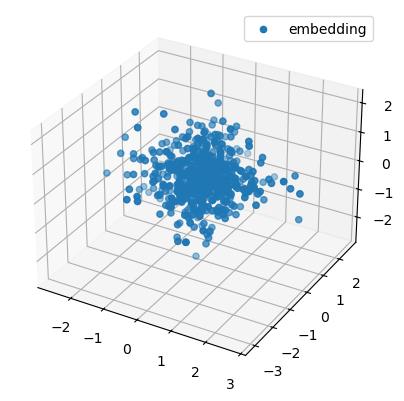

In [65]:
T_labels  # T_labels issus du Training 
trainer.model.eval()   # pas grad, pas de dropout 
with torch.no_grad():
    output = trainer.model.Tembedding(T_labels.long())

X1,Y1,Z1 = output[:,0].numpy(),output[:,1].numpy(),output[:,2].numpy()

x = np.arange(len(X1))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X1,Y1,Z1,label = 'embedding')
ax.legend()
plt.show()

180.93881225585938 0.955689063266307
143.93115234375 0.8975600784698382


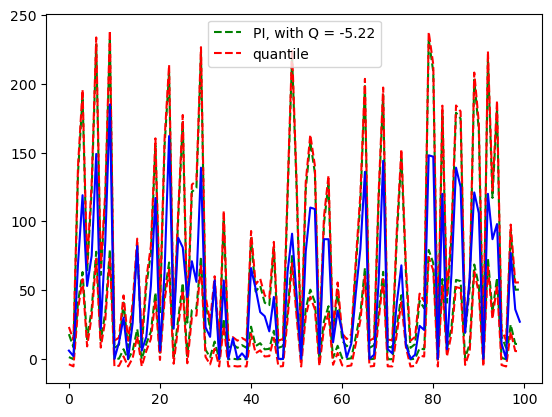

In [4]:
for training_mode in ['cal','train','validate','test']:
    print(training_mode)
    Pred_cal,Y_true_cal =trainer.test_prediction(allow_dropout = False,training_mode = 'cal')
    unorm_Pred_cal,unorm_Y_true_cal = dataset.unormalize_tensor(Pred_cal),dataset.unormalize_tensor(Y_true_cal)

    # PI 'classic' :
    pi_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, type_calib = 'classic')
    print(pi_cal.mpiw,pi_cal.picp)

    # PI 'CQR' : 
    pi_cqr_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, Q = Q, type_calib = 'CQR')
    print(pi_cqr_cal.mpiw,pi_cqr_cal.picp)

    plt.plot(np.arange(100),pi_cqr_cal.upper[:100,0,0],color = 'green',linestyle = 'dashed',label = f"PI, with Q = {'{:.2f}'.format(pi_cqr_cal.Q[0,0,0].item())}")
    plt.plot(np.arange(100),pi_cqr_cal.lower[:100,0,0],color = 'green',linestyle = 'dashed')
    plt.plot(np.arange(100),pi_cal.upper[:100,0,0],color = 'red',linestyle = 'dashed',label = 'quantile')
    plt.plot(np.arange(100),pi_cal.lower[:100,0,0],color = 'red',linestyle = 'dashed')
    plt.plot(np.arange(100),unorm_Y_true_cal[:100,0,0],color = 'blue')
    plt.legend()

In [14]:
# PI des quantiles est trop large (97%). Donc, Q devrait être négatif 
model = trainer.model
model.eval()
with torch.no_grad():
    data = [[x_b,y_b] for  x_b,y_b in trainer.dataloader['cal']]
    X_cal,Y_cal = torch.cat([x_b for [x_b,y_b] in data]),torch.cat([y_b for [x_b,y_b] in data])
    preds = model(X_cal) # x_cal is normalized

    # get lower and upper band
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    
    # unormalized lower band, upper band, and Y_cal 
    lower_q, upper_q = dataset.unormalize_tensor(lower_q),dataset.unormalize_tensor(upper_q)
    Y_cal = dataset.unormalize_tensor(Y_cal)

    # Confority scores and quantiles
    if args.conformity_scores_type == 'max_residual':
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if args.conformity_scores_type == 'max_residual_plus_middle':
        print("|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'")
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function 

    quantile_order = torch.Tensor([np.ceil((1 - args.alpha)*(X_cal.size(0)+1))/X_cal.size(0)])
    Q = torch.quantile(conformity_scores, quantile_order, dim = 0) #interpolation = 'higher'

In [15]:
lower_q[:10,0,0],upper_q[:10,0,0],Y_cal[:10,0,0]

(tensor([ 27.0295,   2.3823, -10.6389, -11.9061, -11.9061,  -8.5437,  33.5009,
          41.8354,  46.4636, -12.4527]),
 tensor([177.8735,  67.0889,  53.7768,  37.4192,  37.4192,  36.1508, 213.2399,
         254.6087, 287.3973,  38.0547]),
 tensor([124.,  27.,  39.,   0.,   0.,  31., 109., 106., 121.,   4.]))

0.36081740260124207 0.9917475728155339


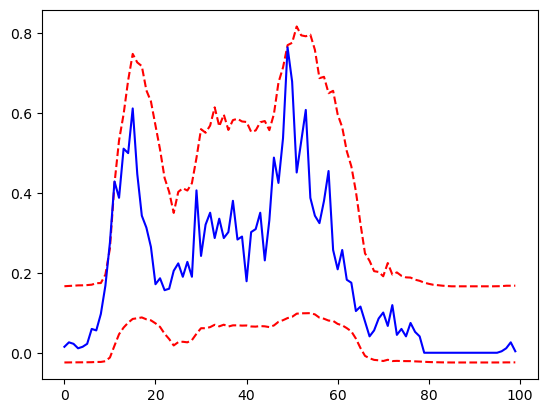

In [12]:
Pred_test,Y_true_test =trainer.test_prediction(allow_dropout = False,training_mode = 'test')
pi_test = PI_object(Pred_test,Y_true_test,alpha = args.alpha, type_calib = 'classic')
print(pi_test.mpiw,pi_test.picp)

plt.plot(np.arange(100),Pred_test[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_test[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_test[:100,0,0],color = 'blue')

0.34379279613494873 0.9918358340688438


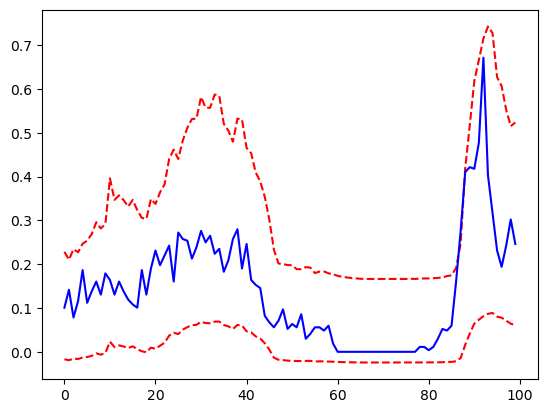

In [14]:
Pred_valid,Y_true_valid =trainer.test_prediction(allow_dropout = False,training_mode = 'validate')
pi_valid = PI_object(Pred_valid,Y_true_valid,alpha = args.alpha, type_calib = 'classic')
print(pi_valid.mpiw,pi_valid.picp)

plt.plot(np.arange(100),Pred_valid[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_valid[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_valid[:100,0,0],color = 'blue')

0.34810584783554077 0.9901325478645067


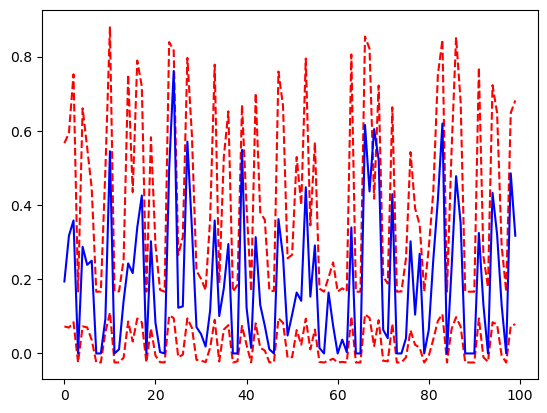

In [23]:
Pred_train,Y_true_train =trainer.test_prediction(allow_dropout = False,training_mode = 'train')
pi_train = PI_object(Pred_train,Y_true_train,alpha = args.alpha, type_calib = 'classic')
print(pi_train.mpiw,pi_train.picp)

plt.plot(np.arange(100),Pred_train[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_train[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_train[:100,0,0],color = 'blue')

A priori, ça ne sert à rien de les projeté dans un espace de plus grande dimension.
- J'ai un ensemble de 'mot'. Chaque mot correspond a une combinaison (d,h,m).
- Il y a 7 jours, 24h, 4 time-step de minute (0,15,30,45). Donc j'ai un ensemble de 4*7*24 = 672 mots.
- J'aimerais faire un embedding de ces mots. C'est a dire représenter chaque mot par un vecteur. 

Exemple : 
(0,7,0) est 'Lundi 8h15'. J'en fais un embedding (donc une projection) dans un espace latent (exemple en dimension 3):


**Problème** : très peu d'occurence de chacun des 'mots' (En tout une semaine pour balayer une seule fois chaucn des mots possible. Donc 1 an de Training c'est seulement 57 apparitions...)